<a href="https://colab.research.google.com/github/AshmithaMB/Text-Classification/blob/main/Product_Attribute_Label_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####***Project Statement & Project Overview***

> *The objective of this project is to develop a machine learning model for text classification, specifically focusing on product attributes. The model will be trained on a dataset consisting of text paragraphs describing various product features and attributes.*

> *By leveraging natural language processing (NLP) techniques and advanced machine learning algorithms, the project aims to automate the categorization of product attributes, enabling efficient analysis and organization of product data*

  ##### ***The Input file consists of two csv files:***

1. ***train_data.csv:***
 > *This file is used for training and contains two fields, namely "text" and "id".*

 > *The "text" field holds the input data, while the "id" field is a unique number assigned to each text.*

 > *This "id" serves as a reference to link the text with its corresponding labels in the "train_label.csv" file.*

2. ***train_label.csv :***

 > *This file contains two fields, "id" and "label". The "id" field in this file corresponds to the "id" field in the "train_data.csv" file.*

 > *It acts as a key to match the labels with the respective input texts.*

 > *The "label" field holds the corresponding labels for each text identified by the "id".*

### ***Importing the Libraries***

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from gensim.models import Word2Vec

from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### *Loading the CSV files*

In [ ]:
data = pd.read_csv("train_data.csv", encoding='UTF-8')
data.head(1)

,text,id
0,"Keep your gloves, hats, coats and jackets toge...",122885


In [ ]:
datalabels = pd.read_csv("train_label.csv", encoding='latin-1')
datalabels.head(5)

,id,label
0,100003,Shape
1,100004,Voltage (volts)
2,100004,Wattage (watts)
3,100006,Wattage (watts)
4,100007,ENERGY STAR Certified


### *Merging the DataFarmes*

In [ ]:
df = pd.merge(data, datalabels, on='id')
df

,text,id,label
0,"Keep your gloves, hats, coats and jackets toge...",122885,Assembly Required
1,"Keep your gloves, hats, coats and jackets toge...",122885,Finish
2,"Keep your gloves, hats, coats and jackets toge...",122885,Hardware Included
3,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958,Commercial / Residential
4,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958,Features
...,...,...,...
75165,This industrial grade anti-fatigue mat is engi...,171764,Features
75166,This industrial grade anti-fatigue mat is engi...,171764,Flooring Product Type
75167,This industrial grade anti-fatigue mat is engi...,171764,Indoor/Outdoor
75168,The Nite Ize LED Upgrade Kit converts most C/D...,117326,Package Quantity


#### *Data Cleaning*
* *The original dataframe contained duplicated texts with unique labels associated with them.*

* *To address this, I grouped the dataframe based on the texts and aggregated the labels.*

* *This allowed to create a new dataframe with unique text values and their corresponding aggregated labels.*

* *Initially, the original dataframe had 15 unique labels. However, due to the duplication of texts, the new dataframe may have additional unique labels.*

* *The IDs associated with the texts were not necessary for building the model, so they were not included in the new dataframe.*
> *The resulting dataframe would have unique texts, but the labels might not be unique.*

In [ ]:
df_grouped = df.groupby('text').agg({'id': list, 'label': lambda x: ', '.join(set(x))}).reset_index()
df_grouped['labels'] = df_grouped['label']
final_df = df_grouped[['text', 'labels']]

In [ ]:
final_df

,text,labels
0,"""Constructor"" Prelude door locks feature moder...","Hardware Included, Finish"
1,"""Constructor"" Prelude door locks feature moder...","Hardware Included, Finish"
2,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish"
3,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish"
4,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish"
...,...,...
41564,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified"
41565,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified"
41566,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified"
41567,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified"


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41569 entries, 0 to 41568
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    41569 non-null  object
 1   labels  41569 non-null  object
dtypes: object(2)
memory usage: 649.6+ KB


### *Exploratory Data Analysis*

#### *Analyzing `Label` Column*

In [ ]:
label_counts = final_df['labels'].value_counts()
unique_labels = len(label_counts)
print("Number of unique labels:", unique_labels)

Number of unique labels: 225


In [ ]:
label_counts

Tools Product Type                                                                  3369
Package Quantity                                                                    2303
Color                                                                               2157
Assembly Required                                                                   2014
Commercial / Residential, Indoor/Outdoor, Flooring Product Type                     1755
                                                                                    ... 
Color, Indoor/Outdoor, ENERGY STAR Certified                                           1
Commercial / Residential, Indoor/Outdoor, ENERGY STAR Certified                        1
Voltage (volts), Commercial / Residential, Indoor/Outdoor, ENERGY STAR Certified       1
Package Quantity, Included, Shape                                                      1
Assembly Required, Color, Indoor/Outdoor, Hardware Included                            1
Name: labels, Length:

In [ ]:
highest_count = label_counts.max()
lowest_count = label_counts.min()
average_count = label_counts.mean()

print("Highest Label Count:", highest_count)
print("Lowest Label Count:", lowest_count)
print("Average Label Count:", average_count)

Highest Label Count: 3369
Lowest Label Count: 1
Average Label Count: 184.7511111111111


In [ ]:
quartiles = np.percentile(label_counts, [25, 50, 75])
iqr_25 = quartiles[0]
iqr_50 = quartiles[1]
iqr_75 = quartiles[2]

print("IQR at 25% :", iqr_25)
print("IQR 50% :", iqr_50)
print("IQR at 75% :", iqr_75)

IQR at 25% : 2.0
IQR 50% : 15.0
IQR at 75% : 126.0


* *The label counts in the data show a significant imbalance. On average, each label appears around 184 times, but looking at the middle value (50th percentile) of the label counts, it drops down to just 15. This suggests that a few labels are appearing much more frequently than others.*
* *The highest label count reaches 3369, which is considerably higher than the 75th percentile value of 126. This wide range between the highest count and the upper quartile indicates a significant imbalance in label distribution.*

In [ ]:
label_counts

Tools Product Type                                                                  3369
Package Quantity                                                                    2303
Color                                                                               2157
Assembly Required                                                                   2014
Commercial / Residential, Indoor/Outdoor, Flooring Product Type                     1755
                                                                                    ... 
Color, Indoor/Outdoor, ENERGY STAR Certified                                           1
Commercial / Residential, Indoor/Outdoor, ENERGY STAR Certified                        1
Voltage (volts), Commercial / Residential, Indoor/Outdoor, ENERGY STAR Certified       1
Package Quantity, Included, Shape                                                      1
Assembly Required, Color, Indoor/Outdoor, Hardware Included                            1
Name: labels, Length:

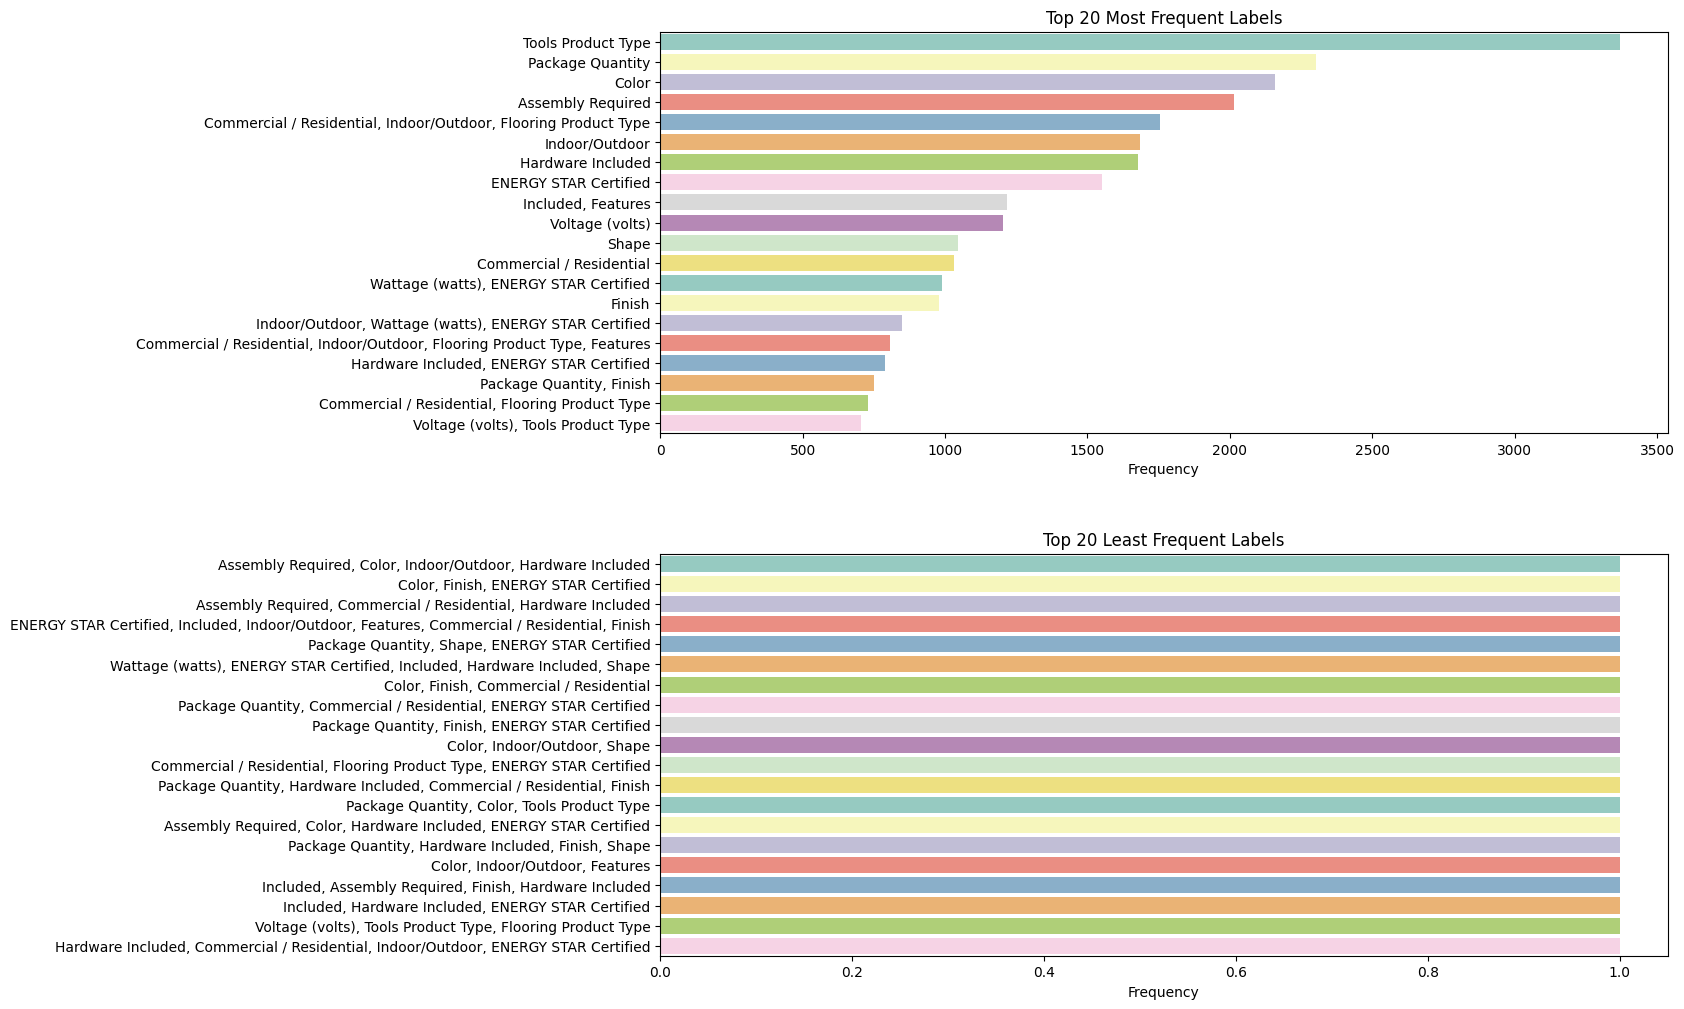

In [ ]:
top_n = 20

top_frequent_labels = label_counts.sort_values(ascending=False).head(top_n)
top_least_frequent_labels = label_counts.sort_values(ascending=True).head(top_n)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 12))

colors = sns.color_palette('Set3', n_colors=top_n)

sns.barplot(y=top_frequent_labels.index, x=top_frequent_labels, ax=ax1, palette=colors)
ax1.set_title(f'Top {top_n} Most Frequent Labels')
ax1.set_xlabel('Frequency')

sns.barplot(y=top_least_frequent_labels.index, x=top_least_frequent_labels, ax=ax2, palette=colors)
ax2.set_title(f'Top {top_n} Least Frequent Labels')
ax2.set_xlabel('Frequency')

plt.subplots_adjust(hspace=0.3)


* The label `Tools Product Type` is the most repeated label, appearing over 3400 times in the dataset.
* Following closely are the labels "Package Quantity" and "Color," which are repeated around 2300-2400 times.
* The top 15 most frequent labels consist mainly 11 out of 15 original labels, with only 4 newer aggregated labels which resulted from combining multiple labels from the original set.
* This could be because 11 out of 15 original labels, had duplicated texts associated with them, resulting in a larger number of occurrences for those labels.
* In contrast, the least frequent labels are exclusively composed of these newly aggregated labels.
* Since these labels combine different variations and categories from the original set, their occurrence is limited to just one instance.


#### *Analyzing `Text` Column*

In [ ]:
dff = final_df.groupby('labels')['text'].apply(list).reset_index(name='Texts')
dff['Paragraphs'] = dff['Texts'].apply(lambda x: len(x))
dff['Words'] = dff['Texts'].apply(lambda x: len(' '.join(x).split()))
dff

,labels,Texts,Paragraphs,Words
0,Assembly Required,[3-Piece Bistro Set Includes Outdoor Dining Ta...,2014,313561
1,"Assembly Required, Color",[A fun way to bake individual deep dish pizzas...,251,31838
2,"Assembly Required, Color, Finish",[Add classic elegance to your bedroom with thi...,19,1950
3,"Assembly Required, Color, Finish, Hardware Inc...",[This multi-purpose boot tray is as versatile ...,2,399
4,"Assembly Required, Color, Finish, Shape",[4000 series deluxe mail slots are made of bra...,4,416
...,...,...,...,...
220,"Wattage (watts), ENERGY STAR Certified",[100 watt metal halide outdoor area light with...,988,105390
221,"Wattage (watts), ENERGY STAR Certified, Includ...",[The cornerstone of the Lenor Collection is qu...,1,86
222,"Wattage (watts), Included, Shape, Voltage (vol...","[American Standard Whirlpools, air baths and c...",1,101
223,"Wattage (watts), Included, Voltage (volts), Shape","[A one-of-a-kind Whirlpool for 2. This unique,...",135,21410


* *The `Texts` column shows the list of all the texts grouped by their corresponding labels.*

* *The `Paragraphs` column represents the count of individual text for each label.*

* *The `Words` column displays the count of words for each label.*

  > *By using these columns, we can understand how many texts (paragraphs) and words are associated with each label in the dataset.*

In [ ]:
top_n = 20

top_labels = label_counts.sort_values(ascending=False)[:top_n]
total_occurrences = top_labels.sum()
print("Total Occurrences of Top 20 Labels:", total_occurrences)

total_occurrences = label_counts.sum()
print("Total Occurrences of All the 225 Labels:", total_occurrences)

Total Occurrences of Top 20 Labels: 27610
Total Occurrences of All the 225 Labels: 41569



* *Analyzing the top 20 labels, out of the total of 225, as they have a combined count of 27610, which accounts for about 66.43% of the total count of 41569.*

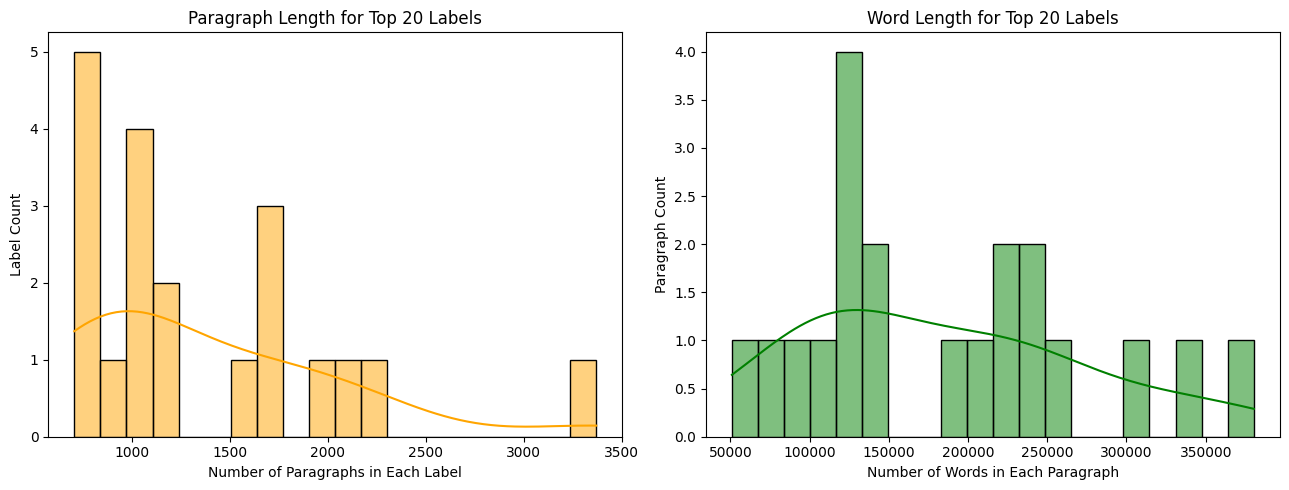

In [ ]:
top_20_labels = dff.nlargest(20, 'Paragraphs')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

sns.histplot(top_20_labels['Paragraphs'], bins=20, color='orange', kde = True, ax=axes[0])
axes[0].set_title('Paragraph Length for Top 20 Labels')
axes[0].set_xlabel('Number of Paragraphs in Each Label')
axes[0].set_ylabel("Label Count")

sns.histplot(top_20_labels['Words'], bins=20, color='green', kde = True, ax=axes[1])
axes[1].set_title('Word Length for Top 20 Labels')
axes[1].set_xlabel('Number of Words in Each Paragraph')
axes[1].set_ylabel("Paragraph Count")

plt.tight_layout()


*Analysis of Top 20 Labels:*

***Paragraph Length:***

* 12 labels have 500-1200 paragraphs.
* 7 labels have 1500-2250 paragraphs.
* Only 1 label has 3500 paragraphs.

***Word Length:***

* 10 out of 20 labels have a word count of 50,000 to 150,000.
* 5 labels have 200,000-250,000 words.
* Only 3 out of 20 labels have 300,000-370,000 words.

In [ ]:
top_n = 200

top_labels = label_counts.sort_values(ascending=True)[:top_n]
total_occurrences = top_labels.sum()
print("Total Occurrences of Top 200 Labels:", total_occurrences)

total_occurrences = label_counts.sum()
print("Total Occurrences of All the 225 Labels:", total_occurrences)

Total Occurrences of Top 200 Labels: 10994
Total Occurrences of All the 225 Labels: 41569


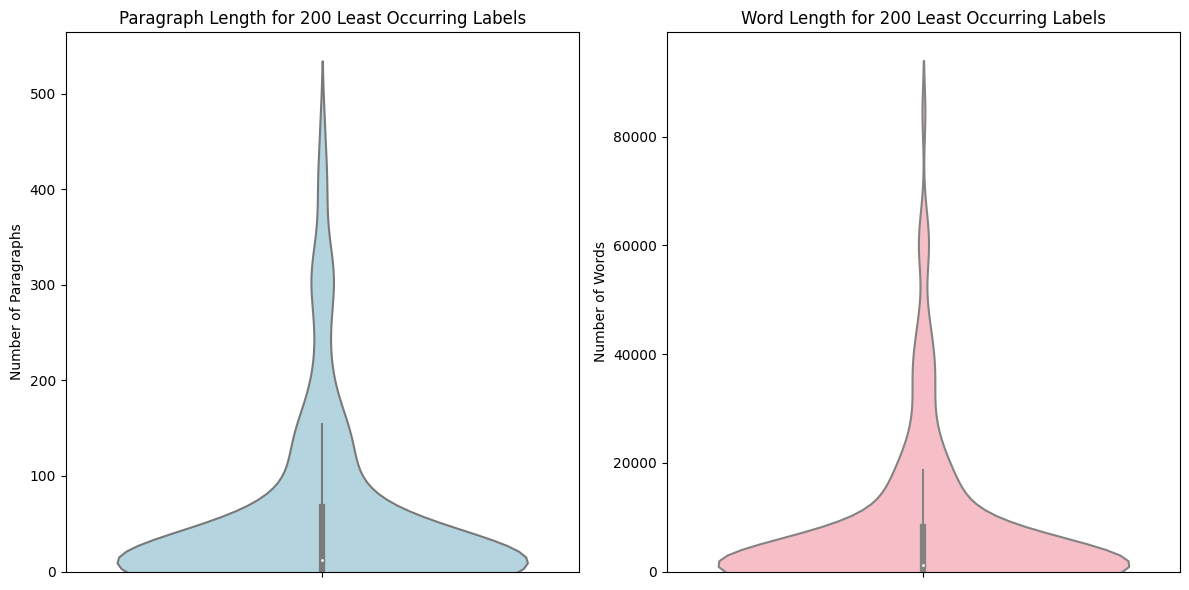

In [ ]:
least_100_labels = dff.nsmallest(200, 'Paragraphs')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(y=least_100_labels['Paragraphs'], color='lightblue', ax=ax1)
ax1.set_title('Paragraph Length for 200 Least Occurring Labels')
ax1.set_ylabel('Number of Paragraphs')
ax1.set_ylim(bottom=0)

sns.violinplot(y=least_100_labels['Words'], color='lightpink', ax=ax2)
ax2.set_title('Word Length for 200 Least Occurring Labels')
ax2.set_ylabel('Number of Words')
ax2.set_ylim(bottom=0)

plt.tight_layout();

##### *Analysis of Paragraph and Word Length for 200 Least Occurring Labels*


***Paragraph Length***
 * *The majority of labels in this subset have less than 100 paragraphs*
 * *However, a small number of labels have a paragraph count ranging from 100 to 300.*
 * *The maximum count observed is 550, but these higher counts are extremely rare, with only 1 or 2 labels having such occurrences.*

***Word Length***
* *Majority of the labels among the least occurring 200 labels have a word count below 200,000.*
* *Another small group of labels fall within the word count range of 200,000 to 600,000*
* *However, labels with word counts above 600,000 are with only a negligible number of occurrences.*

### ***Text Preprocessing***

* *Punctuation Removal*
* *Lower - casing*
* *Tokenization*
* *Stopwords Removal*
* *Lemmatization*


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [ ]:
final_df['processed_text'] = final_df['text'].apply(preprocess_text)

<ipython-input-21-739c49fadc34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['processed_text'] = final_df['text'].apply(preprocess_text)


In [ ]:
tokenized_texts = final_df['processed_text'].apply(lambda x: x.split())
final_df

,text,labels,processed_text
0,"""Constructor"" Prelude door locks feature moder...","Hardware Included, Finish",`` constructor '' prelude door lock feature mo...
1,"""Constructor"" Prelude door locks feature moder...","Hardware Included, Finish",`` constructor '' prelude door lock feature mo...
2,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish",`` constructor '' offer premium classic style ...
3,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish",`` constructor '' offer premium classic style ...
4,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish",`` constructor '' offer premium classic style ...
...,...,...,...
41564,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 1-...
41565,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 2-...
41566,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 3-...
41567,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 3-...


In [ ]:
tokenized_labels = [label.split() for label in final_df['labels']]

In [ ]:
model = Word2Vec(tokenized_labels, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
label_embeddings = []

for label in final_df['labels']:
    if label in model.wv:
        label_embeddings.append(model.wv[label])
    else:
        label_embeddings.append([0] * 100)

In [ ]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(label_embeddings)

In [ ]:
final_df['cluster_labels'] = cluster_labels

In [ ]:
final_df

,text,labels,processed_text,cluster_labels
0,"""Constructor"" Prelude door locks feature moder...","Hardware Included, Finish",`` constructor '' prelude door lock feature mo...,0
1,"""Constructor"" Prelude door locks feature moder...","Hardware Included, Finish",`` constructor '' prelude door lock feature mo...,0
2,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish",`` constructor '' offer premium classic style ...,0
3,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish",`` constructor '' offer premium classic style ...,0
4,"""Constructor"" offers premium classic style doo...","Hardware Included, Finish",`` constructor '' offer premium classic style ...,0
...,...,...,...,...
41564,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 1-...,0
41565,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 2-...,0
41566,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 3-...,0
41567,the great outdoors by Minka Lavery Irvington M...,"Wattage (watts), ENERGY STAR Certified",great outdoors minka lavery irvington manor 3-...,0


In [67]:
cluster_label_mapping = final_df[['cluster_labels', 'labels']].drop_duplicates().sort_values('cluster_labels')
cluster_label_mapping.head(11)

,cluster_labels,labels
0,0,"Hardware Included, Finish"
4758,0,"Indoor/Outdoor, Wattage (watts)"
4784,0,"Hardware Included, Wattage (watts), ENERGY STA..."
4837,0,"Voltage (volts), Wattage (watts), Shape, ENERG..."
5105,0,"Color, Features"
5120,0,"Assembly Required, Hardware Included, Indoor/O..."
5477,0,"Included, Voltage (volts), Features"
5675,0,"Voltage (volts), Color"
5859,0,"Included, Color, Wattage (watts), Shape"
6422,0,"Voltage (volts), Commercial / Residential, Wat..."


### *Building the Model*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df['processed_text'],
                                                    final_df['cluster_labels'],
                                                    test_size=0.1,
                                                    random_state=444)

#### *Linear Support Vector Classifier*

In [ ]:
%%time
pipeline = Pipeline([
    ('Tfidf Vectorizer', TfidfVectorizer()),
    ('ML Model', LinearSVC())])

model_LinearSVC = pipeline.fit(X_train, y_train)
predictions = model_LinearSVC.predict(X_test)

print('ML Model - Linear SVC\n')

accuracy_LinearSVC = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LinearSVC * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


ML Model - Linear SVC

Accuracy Score: 95.81%

Confusion Matrix
[[3473   11    4    2   19    3    5]
 [  18   94    0    0    0    0    1]
 [  23    0   65    0    2    0    0]
 [  11    0    0   39    0    0    0]
 [  38    0    0    0  159    0    1]
 [  12    0    0    0    0   25    0]
 [  22    0    0    0    2    0  128]]

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3517
           1       0.90      0.83      0.86       113
           3       0.94      0.72      0.82        90
           4       0.95      0.78      0.86        50
           5       0.87      0.80      0.84       198
           6       0.89      0.68      0.77        37
           9       0.95      0.84      0.89       152

    accuracy                           0.96      4157
   macro avg       0.92      0.81      0.86      4157
weighted avg       0.96      0.96      0.96      4157

CPU times: user 6.58 s, sys: 57.6 ms, total: 6.64

#### *K-Nearest Neighbors Classifier*

In [ ]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', KNeighborsClassifier(n_neighbors=10, weights='distance'))])

model_KNN1 = pipeline.fit(X_train, y_train)
predictions = model_KNN1.predict(X_test)
print('ML Model - K Nearest Neighbors\n')

accuracy_KNN1 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_KNN1 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - K Nearest Neighbors

Accuracy Score: 95.45%

Confusion Matrix
[[3466   15    7    3   16    5    5]
 [  23   86    1    0    2    0    1]
 [  26    2   61    0    0    1    0]
 [  11    0    0   38    1    0    0]
 [  35    0    1    0  161    1    0]
 [   8    0    0    0    0   29    0]
 [  23    0    0    0    2    0  127]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3517
           1       0.83      0.76      0.80       113
           3       0.87      0.68      0.76        90
           4       0.93      0.76      0.84        50
           5       0.88      0.81      0.85       198
           6       0.81      0.78      0.79        37
           9       0.95      0.84      0.89       152

    accuracy                           0.95      4157
   macro avg       0.89      0.80      0.84      4157
weighted avg       0.95      0.95      0.95      4157

CPU times: user 22min 47s, sys: 834 ms, 

#### *Logistic Reggression*

In [ ]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', LogisticRegression())])

model_LogR = pipeline.fit(X_train, y_train)


predictions = model_LogR.predict(X_test)

accuracy_LogR = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_LogR * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

Accuracy Score: 93.17%

Confusion Matrix
[[3484    8    2    1   17    4    1]
 [  45   64    0    1    3    0    0]
 [  38    0   51    0    1    0    0]
 [  26    0    0   24    0    0    0]
 [  63    0    0    0  134    0    1]
 [  23    0    0    0    0   14    0]
 [  47    0    0    0    3    0  102]]

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3517
           1       0.89      0.57      0.69       113
           3       0.96      0.57      0.71        90
           4       0.92      0.48      0.63        50
           5       0.85      0.68      0.75       198
           6       0.78      0.38      0.51        37
           9       0.98      0.67      0.80       152

    accuracy                           0.93      4157
   macro avg       0.90      0.62      0.72      4157
weighted avg       0.93      0.93      0.93      4157

CPU times: user 39.9 s, sys: 23.3 s, total: 1min 3s
Wall time: 38.9 s


#### *Decision Tree Classifier*

In [ ]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', DecisionTreeClassifier(criterion='entropy',
                                        splitter='best',
                                        max_depth=10,
                                        random_state=33))])

model_DT = pipeline.fit(X_train, y_train)
predictions = model_DT.predict(X_test)
print('ML Model - Decision Tree\n')

accuracy_DT = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_DT * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))

ML Model - Decision Tree

Accuracy Score: 87.44%

Confusion Matrix
[[3494    3    2    4   10    1    3]
 [  93   20    0    0    0    0    0]
 [  54    1   35    0    0    0    0]
 [  28    0    0   19    2    0    1]
 [ 158    0    2    0   38    0    0]
 [  33    0    0    0    0    4    0]
 [ 126    0    0    0    1    0   25]]

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3517
           1       0.83      0.18      0.29       113
           3       0.90      0.39      0.54        90
           4       0.83      0.38      0.52        50
           5       0.75      0.19      0.31       198
           6       0.80      0.11      0.19        37
           9       0.86      0.16      0.28       152

    accuracy                           0.87      4157
   macro avg       0.83      0.34      0.44      4157
weighted avg       0.87      0.87      0.84      4157

CPU times: user 15.6 s, sys: 50.1 ms, total: 1

#### *AdaBoost Classifier*

In [ ]:
%%time
pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('Tfidf Vectorizer', TfidfTransformer()),
    ('ML Model', AdaBoostClassifier(n_estimators=10, random_state=33))
])

model_AB1 = pipeline.fit(X_train, y_train)
predictions = model_AB1.predict(X_test)
print('ML Model - AdaBoost\n')

accuracy_AB1 = accuracy_score(y_test, predictions)
print(f"Accuracy Score: {round(accuracy_AB1 * 100, 2)}%")

print('\nConfusion Matrix')
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions, zero_division=1))

ML Model - AdaBoost

Accuracy Score: 84.92%

Confusion Matrix
[[3507    3    0    3    0    0    4]
 [ 113    0    0    0    0    0    0]
 [  90    0    0    0    0    0    0]
 [  46    0    0    4    0    0    0]
 [ 198    0    0    0    0    0    0]
 [  37    0    0    0    0    0    0]
 [ 133    0    0    0    0    0   19]]

Classification Report
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3517
           1       0.00      0.00      0.00       113
           3       1.00      0.00      0.00        90
           4       0.57      0.08      0.14        50
           5       1.00      0.00      0.00       198
           6       1.00      0.00      0.00        37
           9       0.83      0.12      0.22       152

    accuracy                           0.85      4157
   macro avg       0.75      0.17      0.18      4157
weighted avg       0.83      0.85      0.79      4157

CPU times: user 9.75 s, sys: 26.9 ms, total: 9.77 s

#### *Predictions*

In [63]:
y_predicted = model_LinearSVC.predict(X_test)
y_predicted

array([9, 0, 0, ..., 5, 0, 0], dtype=int32)

In [64]:
predictions = pd.DataFrame(y_predicted)
predictions

,0
0,9
1,0
2,0
3,0
4,0
...,...
4152,0
4153,0
4154,5
4155,0


#### *Conclusion*

*This project aimed to classify text paragraphs into product attribute labels. The data was meticulously cleaned and duplicates were grouped, resulting in 225 unique labels. Semantic relationships were extracted using Word2Vec and K-means, identifying the top 50 features.*

*The performance of five machine learning models, namely KNN, AdaBoost, Decision Tree, Linear SVC, and Logistic Regression, was evaluated. Among them, the Linear SVC algorithm stood out as the top performer, boasting an impressive accuracy of 96%.*

*Overall, this project showcases the effectiveness of employing natural language processing and machine learning techniques in accurately classifying text.*